In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from metpy.units import units

In [51]:
maskfile = xr.open_mfdataset('/users/davidle/postproc_data/lm_c_PRUDENCE_MASKS_LAND.nc', parallel=True)
mask = xr.where(maskfile.MASK_ANALYSIS,maskfile.FR_LAND,0).values.astype(bool)

In [52]:
ds = xr.open_mfdataset('/scratch/snx3000/davidle/results_soil-moisture-pertubation/analysis/ctrl/analysis/lm_c/histfreq_TOT_PREC_????_jja.nc')
bins = ds.bin_bnds.mean(axis=(0,2)).values[100:] #[100:] -> wet days only

In [67]:
def bootstrap(model, exp, mask):
    ds = xr.open_mfdataset('/scratch/snx3000/davidle/results_soil-moisture-pertubation/analysis/'+exp+'/analysis/'+model+'/histfreq_TOT_PREC_????_jja.nc').TOT_PREC.where(mask)
    
    niter=100
    NrYears=10
    phist = np.zeros((niter,300))

    for i in range(niter):
        ind = np.random.choice(np.arange(NrYears), NrYears, replace=True)
        pr = ds.isel(time=ind, bin=slice(100, None)).mean(dim=['time', 'rlon', 'rlat'])
        rcumsum = pr[::-1].cumsum()[::-1].values
        phist[i,:]=rcumsum/rcumsum[0]
    return phist

In [68]:
def plot(model, ctrl, dry, wet):
    plt.figure(figsize=(12, 9))

    ax = plt.subplot(111)

    # Remove the plot frame lines. They are unnecessary chartjunk.  
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.set_xscale('log')
    ax.set_yscale('log')

    #Ticks
    ax.set_xlim(0.1, 50 )
    ax.set_ylim(0.0001,1.1)

    #ax.set_xticks([0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50])
    #ax.set_yticks([0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5,1])

    ax.get_xaxis().set_major_formatter(mtick.ScalarFormatter())
    #ax.get_yaxis().set_major_formatter(mtick.ScalarFormatter())

    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom=True, top=False,
                    labelbottom=True, left=False, right=False, labelleft=True)

    plt.grid(True, color='C7', linestyle='--', linewidth=1, axis='y',zorder=0)

    plt.plot(bins, np.mean(wet, axis=0), lw=2.5,color='C0',label='WET',linestyle='-',zorder=1)
    plt.fill_between(bins, np.percentile(wet, 84, axis=0), np.percentile(wet, 16, axis=0), alpha=0.2, color='C0', zorder=4)

    plt.plot(bins, np.mean(dry, axis=0), lw=2.5,color='C3',label='DRY',linestyle='-',zorder=2)
    plt.fill_between(bins, np.percentile(dry, 84, axis=0), np.percentile(dry, 16, axis=0), alpha=0.2, color='C3', zorder=5)
    
    plt.plot(bins, np.mean(ctrl, axis=0), lw=2.5, color='black',label='CTRL',linestyle='-',zorder=3)
    plt.fill_between(bins, np.percentile(ctrl, 84, axis=0), np.percentile(ctrl, 16, axis=0), alpha=0.2, color='black', zorder=6)


    plt.savefig(model+'_freq_dist.pdf', bbox_inches='tight')

In [74]:
ctrl12 = bootstrap('lm_c', 'ctrl', mask)
dry12   = bootstrap('lm_c', 'dry25', mask)
wet12   = bootstrap('lm_c', 'wet25', mask)

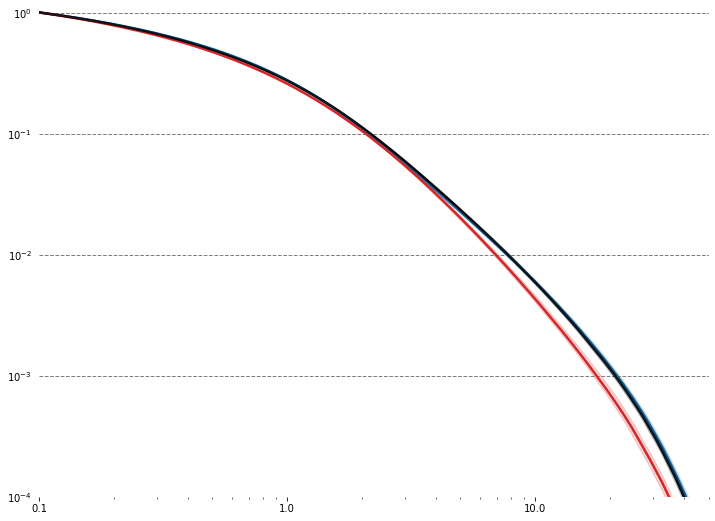

In [76]:
plot('lm_c', ctrl12, dry12, wet12)

In [77]:
maskfile = xr.open_mfdataset('/users/davidle/postproc_data/lm_f_PRUDENCE_MASKS_LAND.nc', parallel=True)
mask = xr.where(maskfile.MASK_ANALYSIS,maskfile.FR_LAND,0).values.astype(bool)

In [78]:
ctrl2= bootstrap('lm_f', 'ctrl', mask)
dry2   = bootstrap('lm_f', 'dry25', mask)
wet2   = bootstrap('lm_f', 'wet25', mask)

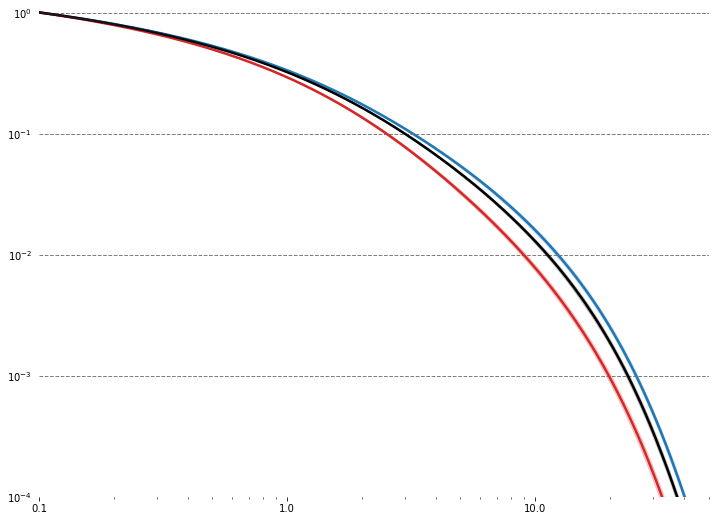

In [79]:
plot('lm_f', ctrl2, dry2, wet2)